### Empirical Example for RobustiPY (Type 2)!

#### This example is designed to show how the OLSRobust class can be used to estimate a model with longitudinal data.

Here we are using a libreary called `unidecode` that needs to be installed in your system before-hand. Using pip, you can installed it with `pip install Unidecode`.

In [1]:
import unidecode
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from robustipy.models import OLSRobust
import statsmodels.formula.api as smf
import warnings
from robustipy.prototypes import MissingValueWarning

# Ignore all MissingValueWarning warnings from robustipy
warnings.filterwarnings(
    action="ignore",
    category=MissingValueWarning,
    module=r"robustipy\.prototypes"
)

Here we are loading the Penn World Table extract and keep only 1985, directly form a source in the web:

In [2]:
df = pd.read_excel(
    'https://dataverse.nl/api/access/datafile/354095',
    sheet_name='Data'
)

Here we are using a dictionary to map country names to original MRW study.
This cell defines a small helper for cleaning up country names that show up in different forms across datasets.
reverse_rename_map lists the tricky cases where a newer or formal name should be replaced by a more familiar one (for example, “Eswatini” becomes “Swaziland” or “Iran (Islamic Republic of)” becomes “Iran”).
normalize_country_name() then standardises any input by trimming spaces, lowering the case, converting accented characters to plain ASCII (via unidecode), and removing apostrophes.
Finally, normalized_reverse_rename_map stores the same replacements but with both keys and values already normalised, so your look-ups and merges will work even when the source data has odd accents, casing, or punctuation.

In [3]:
reverse_rename_map = {
    'Eswatini': 'Swaziland',
    'Gambia': 'Gambia, The',
    'Germany, Fed. Rep.': 'Germany',
    'Iran (Islamic Republic of)': 'Iran',
    'Somali Republic': 'Somalia', 
    "Congo, People's Rep.": "Congo",
    'U.R. of Tanzania: Mainland': 'Tanzania',
    "Côte d’Ivoire": 'Ivory Coast', 
    'D.R. of the Congo': 'Zaire',
    'China, Hong Kong SAR': 'Hong Kong'
}

def normalize_country_name(name):
    # Normalize apostrophes, accents, and lowercase everything
    normalized_name = unidecode.unidecode(name.strip().lower())
    return normalized_name.replace("'", "")  # Remove apostrophes explicitly

normalized_reverse_rename_map = {normalize_country_name(k): normalize_country_name(v) for k, v in reverse_rename_map.items()}

And now we apply the normalization to the whole dataframe:

In [4]:
df['country_normalized'] = df['country'].apply(normalize_country_name)
df['country_normalized'] = df['country_normalized'].replace(normalized_reverse_rename_map)

MRW’s full list of 98 N==1 country names (strip any extra spaces)

We only want to analyse data for the set of countries in the MRW study. Everything else should either raise a flag (“why is that here?”) or remind us we’re missing something we expected.

What happens step-by-step:

- `matching_countries`
A hand-picked list of the countries we care about. Think of it as our “allow list”.

- `matching_countries_normalized`
The same names run through normalize_country_name() so they match the cleaned country_normalized column in your dataframe (accents gone, lower-cased, apostrophes removed, etc.).

- `df_filtered`
A tidy copy of your original dataframe containing only rows whose country_normalized value is on that allow list.

- Sanity checks

non_matching_countries – countries that slipped through but aren’t on the list. These might be misspellings, unexpected alternatives, or genuine outliers.

missing_countries – countries on the list that never show up in the data. Maybe the source is incomplete, or they’re labelled differently.

- Quick print-outs
We immediately print both sets so you can spot issues right away, tweak your mapping, or follow up on data gaps without scrolling through the whole dataframe.


In [5]:
matching_countries = [
    'Algeria', 'Angola', 'Benin', 'Botswana', 'Burkina Faso', 'Burundi', 'Cameroon',
    'Central African Republic', 'Chad', 'Congo', 'Egypt', 'Ethiopia',
    'Gabon', 'Gambia, The', 'Ghana', 'Guinea', 'Ivory Coast', 'Kenya', 'Lesotho',
    'Liberia', 'Madagascar', 'Malawi', 'Mali', 'Mauritania', 'Mauritius', 'Morocco',
    'Mozambique', 'Niger', 'Nigeria', 'Rwanda', 'Senegal', 'Sierra Leone', 'Somalia',
    'South Africa', 'Sudan', 'Swaziland', 'Tanzania', 'Togo', 'Tunisia', 'Uganda',
    'Zaire', 'Zambia', 'Zimbabwe', 'Afghanistan', 'Bahrain', 'Bangladesh', 'Hong Kong',
    'India', 'Iran', 'Israel', 'Japan', 'Jordan', 'Kuwait', 'Malaysia', 'Nepal', 'Oman',
    'Pakistan', 'Philippines', 'Singapore', 'Sri Lanka', 'Syrian Arab Republic', 'Taiwan',
    'Thailand', 'United Arab Emirates', 'Yemen', 'Austria', 'Belgium', 'Cyprus', 'Denmark',
    'Finland', 'France', 'Germany', 'Greece', 'Iceland', 'Ireland', 'Italy', 'Luxembourg',
    'Malta', 'Netherlands', 'Norway', 'Portugal', 'Spain', 'Sweden', 'Switzerland', 'United Kingdom',
    'Canada', 'Costa Rica', 'Dominican Republic', 'El Salvador', 'Guatemala', 'Haiti', 'Honduras',
    'Jamaica', 'Mexico', 'Nicaragua', 'Panama', 'Trinidad & Tobago', 'United States'
]

In [6]:
matching_countries_normalized = [normalize_country_name(country) for country in matching_countries]

In [7]:
df_filtered = df[df['country_normalized'].isin(matching_countries_normalized)].copy()

In [8]:
non_matching_countries = set(df_filtered['country_normalized'].unique()) - set(matching_countries_normalized)

In [9]:
missing_countries = set(matching_countries_normalized) - set(df_filtered['country_normalized'].unique())

In [10]:
print("Non-matching countries:", non_matching_countries)
print("Missing countries:", missing_countries)

Non-matching countries: set()
Missing countries: {'trinidad & tobago', 'somalia', 'afghanistan'}


How many countries can we match to the original MRW study?

In [11]:
len(df_filtered['countrycode'].unique())

95

How many countries are in the raw PWT 10.01 file?

In [12]:
len(df['country'].unique())

183

Lets now make a flat 2018 cross sectional dataset that can be used downstream in the regressions and then, ultimately, in robustipy!

In [13]:
# 0. Prep: copy & sort
data = df_filtered.sort_values(['countrycode','year']).copy()

# 1. Per‐worker GDP and pop growth
data['rgdpew']    = data['rgdpe'] / data['emp']
data['popgrowth'] = data.groupby('countrycode')['pop'].diff() / data['pop']

# 2. Investment‐to‐GDP and ln‐saving rate
data['investment'] = (
    data.groupby('countrycode')['ck'].shift(-1)
    - (1 - data['delta']) * data['ck']
)
data['i_y'] = data['investment'] / data['rgdpe']
data.loc[data['i_y'] == 0, 'i_y'] = np.nan
data = data.dropna(subset=['i_y','popgrowth','delta','rtfpna'])
data['ln_i_y'] = np.log(data['i_y'])

# 3. TFP growth and ln(n+g+δ)
data['g']         = data.groupby('countrycode')['rtfpna'].diff() / data['rtfpna']
data['ln_n_plus'] = np.log(data['popgrowth'] + data['g'] + data['delta'])

# 4. Build “pre‐2018” subset
pre2018 = data.loc[data['year'] <= 2018].copy()

# 5a. Avg log saving (ls)
avg_s = (
    pre2018
    .groupby('countrycode', as_index=False)['ln_i_y']
    .mean()
    .rename(columns={'ln_i_y':'avg_ls'})
)

# 5b. Avg ln(n+g+δ)
avg_n = (
    pre2018
    .groupby('countrycode', as_index=False)['ln_n_plus']
    .mean()
    .rename(columns={'ln_n_plus':'avg_ln_n_plus'})
)

# 5c. Terms of Trade: price ratio pl_x / pl_m
pre2018['tot'] = pre2018['pl_x'] / pre2018['pl_m']
avg_tot = (
    pre2018
    .groupby('countrycode', as_index=False)['tot']
    .mean()
    .rename(columns={'tot':'avg_tot'})
)
avg_tot['avg_ln_tot'] = np.log(avg_tot['avg_tot'])

# 5d. Government consumption share: csh_g
avg_gov = (
    pre2018
    .groupby('countrycode', as_index=False)['csh_g']
    .mean()
    .rename(columns={'csh_g':'avg_gov_share'})
)
avg_gov['avg_ln_gov'] = np.log(avg_gov['avg_gov_share'])

# 5e. Avg human capital (augmented Solow)
avg_hc = (
    pre2018
    .groupby('countrycode', as_index=False)['hc']
    .agg(lschool_av=lambda x: np.log(x).mean())
)

# 6. Merge all averages back onto the full panel
data = (
    data
    .merge(avg_s[['countrycode','avg_ls']],       on='countrycode', how='left')
    .merge(avg_n[['countrycode','avg_ln_n_plus']],on='countrycode', how='left')
    .merge(avg_tot[['countrycode','avg_ln_tot']], on='countrycode', how='left')
    .merge(avg_gov[['countrycode','avg_ln_gov']], on='countrycode', how='left')
    .merge(avg_hc[['countrycode','lschool_av']],  on='countrycode', how='left')
)

# 7. Extract the 2018 cross‐section
df2018 = data.loc[data['year'] == 2018].copy()
df2018['ln_rgdpew'] = np.log(df2018['rgdpew'])
df2018['lschool']   = np.log(df2018['hc'])
df2018['ln_pl_i'] = np.log(df2018['pl_i'])

# 8. Initial income: ln(rgdpe) in 1993
df93 = (
    data.loc[data['year'] == 1993, ['countrycode','rgdpe']]
        .drop_duplicates(subset='countrycode')
        .assign(ln_rgdpe93=lambda d: np.log(d['rgdpe']))[['countrycode','ln_rgdpe93']]
)
df2018 = df2018.merge(df93, on='countrycode', how='left')

# 9. Log consumption price level in 2018
df2018['ln_pl_con'] = np.log(df2018['pl_con'])

# 10. Remove missing/infinite values
df2018 = (
    df2018
    .replace([np.inf, -np.inf], np.nan)
    .dropna(subset=[
        'ln_rgdpew','avg_ls','avg_ln_n_plus','lschool',
        'ln_rgdpe93','avg_ln_tot','avg_ln_gov','lschool_av','ln_pl_con'
    ])
)

Run some models, starting with the baseline:

In [14]:
model = smf.ols(
    'ln_rgdpew ~ avg_ls + avg_ln_n_plus',
    data=df2018
).fit(cov_type='HC1')
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:              ln_rgdpew   R-squared:                       0.359
Model:                            OLS   Adj. R-squared:                  0.341
Method:                 Least Squares   F-statistic:                     16.12
Date:                Wed, 03 Sep 2025   Prob (F-statistic):           1.75e-06
Time:                        11:55:09   Log-Likelihood:                -99.888
No. Observations:                  73   AIC:                             205.8
Df Residuals:                      70   BIC:                             212.6
Df Model:                           2                                         
Covariance Type:                  HC1                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        30.4417      6.177      4.929

Full model:

In [15]:
model = smf.ols(
    'ln_rgdpew ~ avg_ls + avg_ln_n_plus + lschool + ln_rgdpe93 '
    '+ avg_ln_tot + avg_ln_gov + lschool_av + ln_pl_con + ln_pl_i',
    data=df2018
).fit(cov_type='HC1')

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              ln_rgdpew   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.820
Method:                 Least Squares   F-statistic:                     42.41
Date:                Wed, 03 Sep 2025   Prob (F-statistic):           2.11e-23
Time:                        11:55:09   Log-Likelihood:                -48.612
No. Observations:                  73   AIC:                             117.2
Df Residuals:                      63   BIC:                             140.1
Df Model:                           9                                         
Covariance Type:                  HC1                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        12.3192      3.980      3.096

Core model with ln(school) (as in paper)

In [16]:
model = smf.ols(
    'ln_rgdpew ~ avg_ls + avg_ln_n_plus + lschool',
    data=df2018
).fit(cov_type='HC1')

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              ln_rgdpew   R-squared:                       0.784
Model:                            OLS   Adj. R-squared:                  0.775
Method:                 Least Squares   F-statistic:                     113.2
Date:                Wed, 03 Sep 2025   Prob (F-statistic):           1.36e-26
Time:                        11:55:09   Log-Likelihood:                -60.208
No. Observations:                  73   AIC:                             128.4
Df Residuals:                      69   BIC:                             137.6
Df Model:                           3                                         
Covariance Type:                  HC1                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        14.5362      4.563      3.185

 Lets use robustipy when `x=['avg_ls', 'avg_ln_n_plus']`: 

You haven’t specified the number of CPUs. Is 31 okay? (yes/no):  yes


Output()

OLSRobust is running with n_cpu=31, draws=1000, folds=10, seed=192735.
We're evaluating our out-of-sample predictions with the pseudo-r2 metric.
The estimand of interest is avg_ls. Let's begin the calculations...
Total model runs: 128,000 (draws=1000, control_specs=128, y_composites=1)


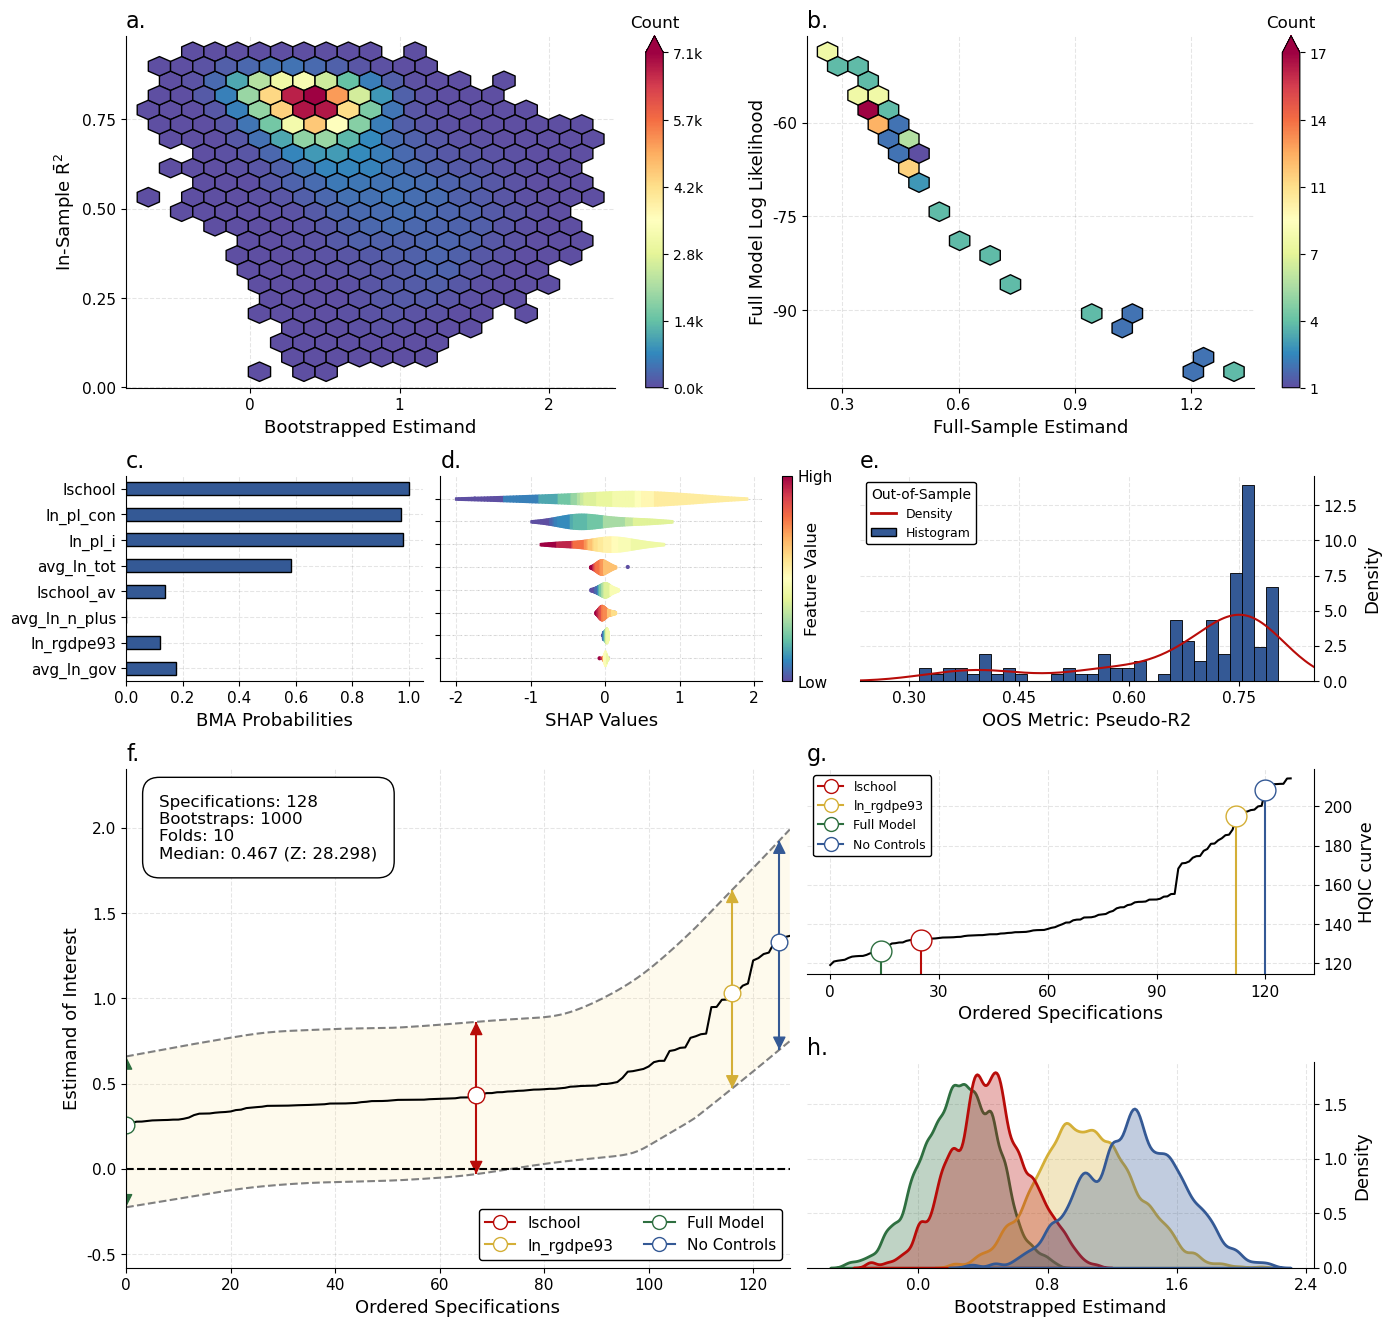

In [17]:
mrw_robust = OLSRobust(y=['ln_rgdpew'],
                       x=['avg_ls',
                          'avg_ln_n_plus'],
                       data=df2018
                      )
mrw_robust.fit(controls=[
                         'lschool',
                         'ln_rgdpe93',
                         'avg_ln_tot',
                         'avg_ln_gov',
                         'lschool_av',
                         'ln_pl_con',
                         'ln_pl_i'
                        ],
               draws=1000,
               kfold=10,
               seed=192735,
               oos_metric='pseudo-r2',
               threshold=1000000)
df_results_ls = mrw_robust.get_results()
df_results_ls.plot(specs=[['lschool'], ['ln_rgdpe93']], ic='hqic',
                   ext='pdf',
                   ci=0.95,
                   loess=True,
                   project_name='mrw_avgls_example',
                   figsize=(16, 16),
                   figpath = '../figures/'
                   )

In [18]:
df_results_ls.summary(digits=2)

1. Model Summary
Model: OLS Robust
Inference Tests: Yes
Dependent variable: ln_rgdpew
Independent variable: avg_ls
Number of possible controls: 7
Number of draws: 1000
Number of folds: 10
Number of specifications: 128
2.Model Robustness Metrics
2.1 Inference Metrics
Median β (specs, no resampling): 0.41 (null-calibrated p: 0)
Median β (bootstraps × specs): 0.47
Min β (specs, no resampling): 0.26
Min β (bootstraps × specs): -0.68
Max β (specs, no resampling): 1.31
Max β (bootstraps × specs): 2.29
AIC-weighted β (specs, no resampling): 0.27
BIC-weighted β (specs, no resampling): 0.30
HQIC-weighted β (specs, no resampling): 0.29
Share significant (specs, no resampling) [descriptive]: 0.86
Share significant (bootstraps × specs) [descriptive]: 0.66  |  null-calibrated p: 0.002
Share β>0 (specs, no resampling) [descriptive]: 1.00
Share β>0 (bootstraps × specs) [descriptive]: 0.96  |  null-calibrated p: 0.002
Share β<0 (specs, no resampling) [descriptive]: 0.00
Share β<0 (bootstraps × specs) 

And then x=[ 'avg_ln_n_plus', 'avg_ls']:

You haven’t specified the number of CPUs. Is 31 okay? (yes/no):  yes


Output()

OLSRobust is running with n_cpu=31, draws=1000, folds=10, seed=192735.
We're evaluating our out-of-sample predictions with the pseudo-r2 metric.
The estimand of interest is avg_ln_n_plus. Let's begin the calculations...
Total model runs: 128,000 (draws=1000, control_specs=128, y_composites=1)


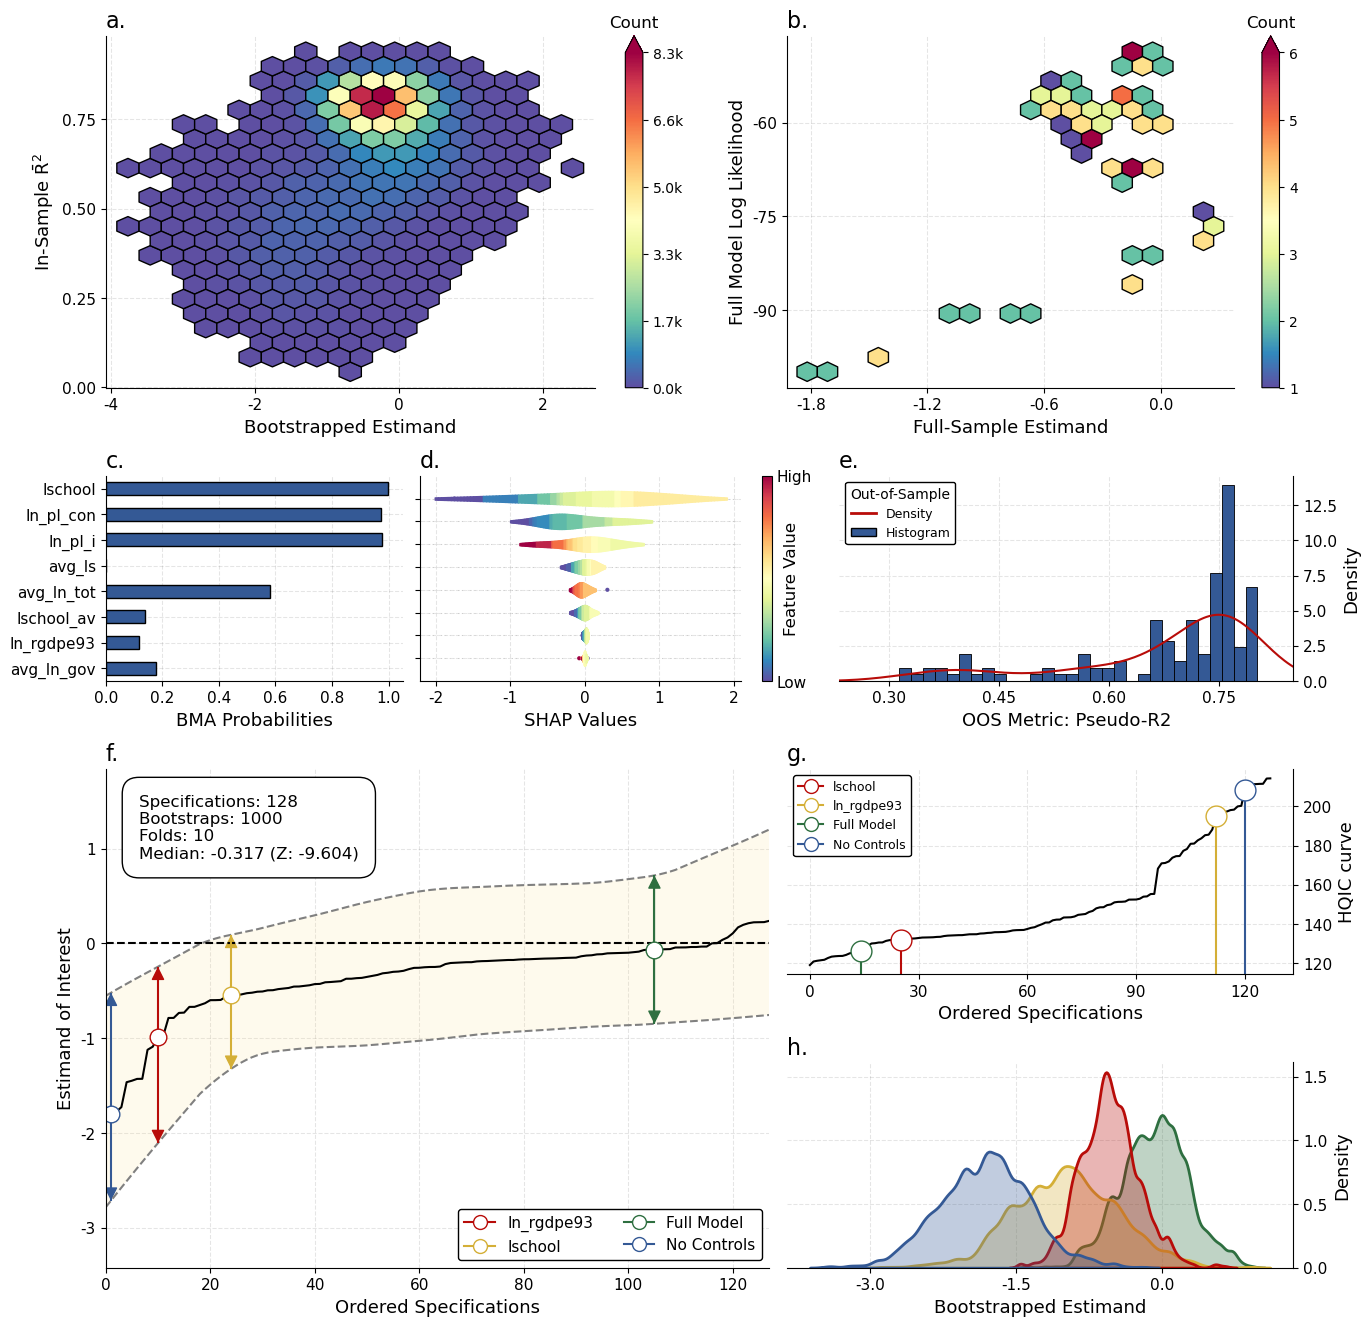

In [19]:
mrw_robust = OLSRobust(y=['ln_rgdpew'],
                       x=[ 'avg_ln_n_plus', 'avg_ls'],
                       data=df2018)
mrw_robust.fit(controls=[
                         'lschool',
                         'ln_rgdpe93',
                         'avg_ln_tot',
                         'avg_ln_gov',
                         'lschool_av',
                         'ln_pl_con',
                         'ln_pl_i'
                        ],
               draws=1000,
               kfold=10,
               seed=192735,
               oos_metric='pseudo-r2',
               threshold=1000000)
df_results_lnn = mrw_robust.get_results()
df_results_lnn.plot(specs=[['lschool'], ['ln_rgdpe93']], ic='hqic',
                    ext='pdf',
                    ci=0.95,
                    loess=True,
                    project_name='mrw_avg_lnnplus_example',
                    figsize=(16, 16),
                    figpath = '../figures/'
                    )

In [20]:
df_results_lnn.summary(digits=2)

1. Model Summary
Model: OLS Robust
Inference Tests: Yes
Dependent variable: ln_rgdpew
Independent variable: avg_ln_n_plus
Number of possible controls: 7
Number of draws: 1000
Number of folds: 10
Number of specifications: 128
2.Model Robustness Metrics
2.1 Inference Metrics
Median β (specs, no resampling): -0.21 (null-calibrated p: 0)
Median β (bootstraps × specs): -0.32
Min β (specs, no resampling): -1.82
Min β (bootstraps × specs): -3.76
Max β (specs, no resampling): 0.27
Max β (bootstraps × specs): 2.41
AIC-weighted β (specs, no resampling): -0.12
BIC-weighted β (specs, no resampling): -0.17
HQIC-weighted β (specs, no resampling): -0.15
Share significant (specs, no resampling) [descriptive]: 0.09
Share significant (bootstraps × specs) [descriptive]: 0.22  |  null-calibrated p: 0.002
Share β>0 (specs, no resampling) [descriptive]: 0.09
Share β>0 (bootstraps × specs) [descriptive]: 0.26  |  null-calibrated p: 0.002
Share β<0 (specs, no resampling) [descriptive]: 0.91
Share β<0 (bootstr

Lets take these two sets of results, and plot them. Note, many entries in the two results object will actually be the same, because all the same models are getting run, but some -- like the bootstrapped estimates -- will vary because of the estimand being different:

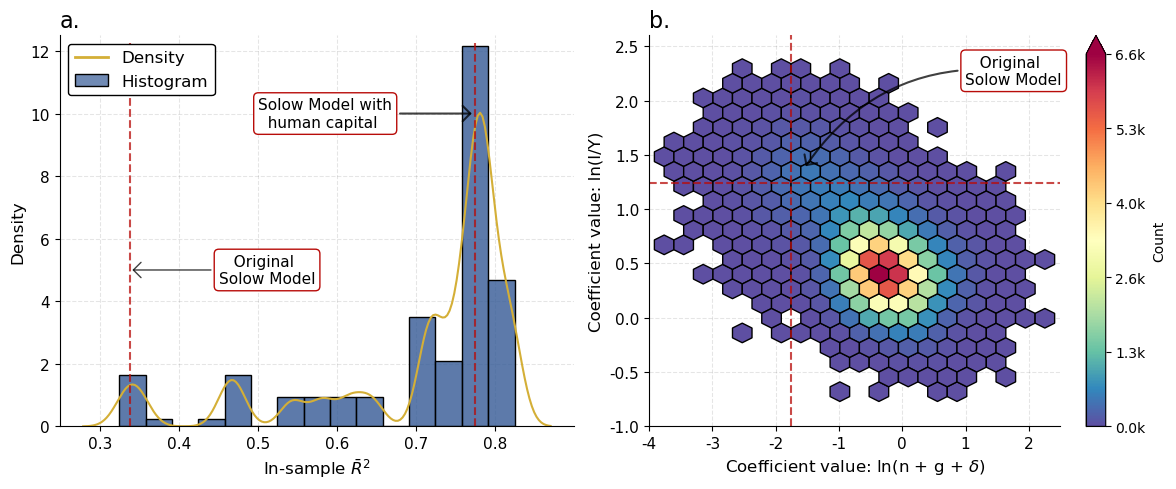

In [21]:
colors=["#345995", "#B80C09", "#D4AF37"]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))





sns.histplot(df_results_ls.summary_df['r2'], edgecolor='k',
             color=colors[0], alpha=0.8, stat='density',
             ax=ax1, bins=15)
sns.kdeplot(df_results_ls.summary_df['r2'], color=colors[2], ax=ax1, common_norm=True, bw_adjust=.3)

legend_elements = [
    Line2D([0], [0], color=colors[2], lw=2, label='Density'),
    Patch(facecolor=(52/255, 89/255, 149/255, 0.7), edgecolor=(0, 0, 0, 1), label='Histogram')
]
ax1.legend(handles=legend_elements,
          loc='upper left',
          frameon=True,
          fontsize=12,
          #title=r'In-sample $\bar{R}^2$',
          title_fontsize=10,
          framealpha=1,
          facecolor='w',
          edgecolor=(0, 0, 0, 1))




image = ax2.hexbin(
    df_results_lnn.estimates.stack(),
    df_results_ls.estimates.stack(),
    cmap='Spectral_r',
    gridsize=20,
    mincnt=1,
    edgecolor="k",
)

# Place the colour-bar opposite the y-axis
#cb_location = "right" if side == "left" else "left"
cb = fig.colorbar(
    image,
    ax=ax2,
    spacing="uniform",
    pad=0.05,
    extend="max",
    location='right',       # Matplotlib ≥ 3.3
)

# ------------------------------------------------------------------ #
# 2.  Colour-bar tick formatting                                     #
# ------------------------------------------------------------------ #
data  = image.get_array()
ticks = np.linspace(data.min(), data.max(), num=6)
cb.set_ticks(ticks)

if 1_000 <= data.max() < 10_000:
    cb.set_ticklabels([f"{t/1_000:.1f}k" for t in ticks])
elif data.max() >= 10_000:
    cb.set_ticklabels([f"{t/1_000:.0f}k" for t in ticks])
else:
    cb.set_ticklabels([f"{t:.0f}"        for t in ticks])

cb.ax.set_ylabel('Count', rotation=90, va='center', labelpad=10)





for ax in [ax1, ax2]:
    ax.tick_params(axis='both', which='major', labelsize=11)
    ax.grid(linestyle='--', color='k', alpha=0.1, zorder=-1)
    ax.set_axisbelow(True)




ax1.set_ylabel('Density', fontsize=12)
ax1.set_xlabel(r'In-sample $\bar{R}^2$', fontsize=12)

ax2.set_ylabel('Coefficient value: ln(I/Y)', fontsize=12)
ax2.set_xlabel(r'Coefficient value: ln(n + g + $\delta$)', fontsize=12)

ax1.set_title('a.', loc='left', fontsize=16, y=1)
ax2.set_title('b.', loc='left', fontsize=16, y=1)







ax1.vlines(
    x=0.337,
    ymin=0,
    ymax=12.25,
    color=colors[1],
    alpha=.75,
    linestyle='--',
    linewidth=1.5,
    label='wat'
)

ax1.vlines(
    x=0.774,
    ymin=0,
    ymax=12.25,
    color=colors[1],
    alpha=.75,
    linestyle='--',
    linewidth=1.5,
    label='wat'
)

ax1.set_ylim(0, 12.5)




ymin, ymax = ax2.get_ylim()
ax2.vlines(
    x=-1.7515,
    ymin=-1,
    ymax=2.6,
    color=colors[1],
    alpha=.75,
    linestyle='--',
    linewidth=1.5,
    label='wat'
)

ax2.hlines(
    y=1.2376,
    xmin=-4,
    xmax=2.5,
    color=colors[1],
    alpha=.75,
    linestyle='--',
    linewidth=1.5,
    label='wat'
)


ax2.set_ylim(-1, 2.6)
ax2.set_xlim(-4, 2.5)



ax1.annotate(
    "   Original\nSolow Model",
    xy=(0.337, 5),
    xytext=(0.45, 5),
    ha='left',
    va='center',
    fontsize=11,
    bbox=dict(boxstyle='round,pad=0.3', fc='white', ec=colors[1], lw=1),
    arrowprops=dict(
        arrowstyle='->,head_length=0.5,head_width=0.5',
        color='k',
        alpha=0.75,
        lw=1
    )
)


ax1.annotate(
    "Solow Model with\n  human capital",
    xy=(0.774, 10),
    xytext=(0.5, 10),
    ha='left',
    va='center',
    fontsize=11,
    bbox=dict(boxstyle='round,pad=0.3', fc='white', ec=colors[1], lw=1),
    arrowprops=dict(
        arrowstyle='->,head_length=0.5,head_width=0.5',
        color='k',
        alpha=0.75,
        lw=1.5
    )
)




ax2.annotate(
    "   Original\nSolow Model",
    xy=(-1.7515+.2, 1.2736+.1),
    xytext=(-1.7515+2.75, 1.2736+1),
    textcoords='data',
    ha='left',
    va='center',
    fontsize=11,
    bbox=dict(boxstyle='round,pad=0.3', fc='white', ec=colors[1], lw=1),
    arrowprops=dict(
        arrowstyle='->,head_length=0.5,head_width=0.5',
        color='k',
        alpha=0.75,
        connectionstyle="arc3,rad=0.3",
        lw=1.5
    )
)


sns.despine()

plt.tight_layout()
import os
os.makedirs(os.path.join('..',
                         'figures',
                         'mrw_example',
                        ),
            exist_ok=True
           )
plt.savefig('../figures/mrw_example/solow_model_results.pdf', bbox_inches='tight')
plt.savefig('../figures/mrw_example/solow_model_results.png', bbox_inches='tight')